**The following file is to calibrate and validate the model with 4 years of data with the results from spinup as the initial condition. Previously in the folder rk_model_final - /home/rk/ats_rk/testing/ats-demos/rk_model/Spinup_final_16032022. The calibration was carried out for only 1 year. All the files will have a similar naming with the ending cv (calibration and validation) and su (spinup).**

* The notebook is developed to code the methodology and extract relevant files that are suitable as input to PEST.
- pestpp/pestpp/benchmarks/mf6_freyberg - This is used as the standard benchmark folder from which the files are referred.
- Currently, the freyberg6_run_glm.pst which solves the Levenberg - Marquardt algorithm is considered.

Parameters considered: 'alpha_p_gp', 'alpha_m_gp', 'n_p_gp', 'n_m_gp', 'wr_p_gp', 'wr_m_gp', 'tcs_p_gp', 'tcs_m_gp', 'tcd_p_gp', 'tcd_m_gp', 'af_p_gp', 'af_m_gp', 'auf_p_gp', 'auf_m_gp', 'por_p_gp', 'por_m_gp', 'perm_p_gp', 'perm_m_gp', 'den_p_gp', 'den_m_gp'

- We are considering the initial parameters based on the simulation : all_params_afterrw.demo

- The lower and upper bound is fixed to 75 % of the initial value

- Some values that do not accept these changes, have been changed with respect to their initial value

- We are considering to reduce the parameter space so that the pest simulation can run quicker. We will be considering the results from calibration of 1 year - Case5_I_E simulation. Considering the file path - pestpp/pestpp/rk_model_final/Output_comp_analysis_3.ipynb. For the parameters that were not considered in the analysis - the calibrated values from 1 year of calibration is taken. All parameters with log_rel_sen < - 8 is not considered. The results are shown below when the command - rel_cases_log.iloc[1,:][rel_cases_log.iloc[1,:] <-8] was run. 

    * n_m         -10.780082
    * wr_m         -8.237805
    * tcs_p        -9.283912
    * tcs_m        -8.707658
    * tcd_p        -8.552841
    * tcd_m       -10.539404
    * af_p        -10.874932
    * af_m        -10.649015
    * auf_p        -8.592941
    * auf_m       -10.588667
    * den_p       -18.200911
    * den_m       -17.717395
    * albedo_bg    -8.457213
    * e_bg         -8.210573
    * pen_w        -8.971497


- The snow depth dataset is available from 2014 - 2017. The meteorological data is available from the year 2016 - 2020. 2020 - 2021 is not considered for the analysis since it contains missing data for nearly 3 months (2020-02 : 2020-05). **Therefore for Case 5 we can consider the year 2016 as calibration dataset and the year 2017 as validation dataset**. This can ensure that we are working with the right kind of dataset for both calibration and validation.


In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
%matplotlib inline
import sys,os
#import colors
import numpy as np
import matplotlib.cm
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import h5py
import pandas as pd
from datetime import datetime
import matplotlib.image as mpimg

In [3]:
import shutil
import numpy as np
import pandas as pd
#import pyemu
#import flopy
import subprocess

In [4]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [5]:
directory_name = 'Case5_III_su_cv_start.demo' # Main directory name where the data is stored for the initial round of calibration
file_name = 'Case5_III_su_cv' # Name of the xml file

In [6]:
os.getcwd()

'/bigwork/nhgjrabl/Simulations/pestpp/rk_model_final_4yrs_su'

### 1. Observation data

In [7]:
df_obs_AWS = pd.read_csv('/home/rk/ats_rk/testing/ats-demos/rk_model/Data/Data_Yakou/Yakou_met_data_ITP_rk/Final_OutputData_Case5/Calib_outputdata_Case5_2016.csv',sep='\t')
df_obs_AWS.head()

# The observation data was processed previously in /home/rk/ats_rk/testing/ats-demos/rk_model/Data/Data_Yakou/Yakou_met_data_ITP_rk/AWS_final_metdata_4yrs_concise.ipynb

FileNotFoundError: [Errno 2] No such file or directory: '/home/rk/ats_rk/testing/ats-demos/rk_model/Data/Data_Yakou/Yakou_met_data_ITP_rk/Final_OutputData_Case5/Calib_outputdata_Case5_2016.csv'

In [12]:
len(df_obs_AWS)

366

In [13]:
# Calculating the temperature in Kelvin

depths = [0.04, 0.1, 0.2, 0.4, 0.8, 1.2, 1.6]

time_values = len(df_obs_AWS) # Number of time values

times = np.arange(1, time_values+1, 1)

# Adding column information:


x = 0
for i, depth in enumerate(depths):
        df_obs_AWS[f'Soil temperature at - {depth} m (K)'] = df_obs_AWS[f'Soil temperature at - {depth} m (°C)'] + 273.15

df_obs_AWS['Soil temperature at - 0.04 m (K)'].head()

0    260.642153
1    261.288403
2    261.325486
3    261.152153
4    260.778403
Name: Soil temperature at - 0.04 m (K), dtype: float64

In [14]:
# Extracting an example 
obs_data_example = pd.read_csv('Freyberg_example/freyberg6_run_glm.obs_data.csv') 
obs_data_example.head()

,obsnme,obsval,weight,obgnme
0,gage_1_20151231,951.71,0.000000,gage
1,gage_1_20160131,1530.10,0.004357,gage
2,gage_1_20160229,1855.30,0.003593,gage
3,gage_1_20160331,1907.10,0.003496,gage
4,gage_1_20160430,1747.70,0.003815,gage


In [16]:
obs_weight = 2 * 7 * 366
obs_weight

5124

The following details need to be defined:

Note: Here we need to add the values from the excel that we read previously.

- OBSNME: stemp_{depth}_{1-366} & smois_{depth}_{1-366}: Observation names - We have temperature and moisture values at 7 depths. 
- OBSVAL: The corresponding values need to be added in pandas from the dataframe - data_AWS_syn_2016
- WEIGHT (Initial): Assigning equal weights to all variables. 1/5124 = 1.9516e-04; 2 {soil_temp, soil_mois} * 7 {7 sensors} * 366 {1-366}  = 5124
- obgnme: 'temp', 'mois'

In [17]:
# Initial values 
time_values = 366 # Number of time values
# Total number of values 1/15344 = 6.517e-05; 2 {soil_temp, soil_mois} * 7 {7 sensors} * 1096 {1-365}  = 15344
total_values = 2 * 7 * 366 
ini_wt = 1/total_values # Initial weight
ini_wt

0.000195160031225605

In [18]:
# Creating a new dataframes with columns = obs_data_example.index and rows = 0 - 15344
# There are 1096 values for one sensor in each year, hence we move from 0 - 1095 & then it repeats again for the next sensor.

obs_data = pd.DataFrame(data=None,columns=obs_data_example.columns,index=np.arange(1,total_values+1,1))


depths = [0.04, 0.1, 0.2, 0.4, 0.8, 1.2, 1.6]

times = np.arange(1, time_values+1, 1)

# Adding column information:


x = 0
for i, depth in enumerate(depths):
    for j, time in enumerate(times):
        # Column name = obsnme
        obs_data.iloc[x,0] = f'stemp_{depth}_{j}'
        # Column name = obsval
        obs_data.iloc[x,1] = df_obs_AWS[f'Soil temperature at - {depth} m (K)'][j]
        # Column name = weights : Assigning equal weight to all variables
        obs_data.iloc[x,2] = 1/total_values
        # Column name = obgnme : Assigning observation group name
        obs_data.iloc[x,3] = 'temp'
        x = x + 1

for i, depth in enumerate(depths):
    for j, time in enumerate(times):
        obs_data.iloc[x,0] = f'smois_{depth}_{j}'
        # Column name = obsval
        obs_data.iloc[x,1] = df_obs_AWS[f'Soil moisture at - {depth} m (%)'][j]
        # Column name = weights : Assigning equal weight to all variables
        obs_data.iloc[x,2] = 1/total_values
        # Column name = obgnme : Assigning observation group name
        obs_data.iloc[x,3] = 'mois'
        x = x + 1

        
obs_data.head()

,obsnme,obsval,weight,obgnme
1,stemp_0.04_0,260.642153,0.000195,temp
2,stemp_0.04_1,261.288403,0.000195,temp
3,stemp_0.04_2,261.325486,0.000195,temp
4,stemp_0.04_3,261.152153,0.000195,temp
5,stemp_0.04_4,260.778403,0.000195,temp


In [20]:
df_obs_AWS['Soil temperature at - 0.2 m (K)'][200:205]

200    279.461694
201    280.641611
202    280.277917
203    279.958944
204    280.124236
Name: Soil temperature at - 0.2 m (K), dtype: float64

In [24]:
# Check the observation values
obs_data.iloc[932:936]

,obsnme,obsval,weight,obgnme
933,stemp_0.2_200,279.461694,0.000195,temp
934,stemp_0.2_201,280.641611,0.000195,temp
935,stemp_0.2_202,280.277917,0.000195,temp
936,stemp_0.2_203,279.958944,0.000195,temp


In [25]:
directory_name

'Case5_III_su_cv_start.demo'

In [26]:
file_name

'Case5_III_su_cv'

In [27]:
# Exporting the observation data csv file
obs_data.to_csv(f'{directory_name}/{file_name}_obs_data.csv', index=False)

### 2. Parameter groups external
- Extracting the data from the example

In [28]:
pargrp_data_example = pd.read_csv('Freyberg_example/freyberg6_run_glm.pargrp_data.csv') 
pargrp_data_example.head()

,pargpnme,inctyp,derinc,derinclb,forcen,derincmul,dermthd,splitthresh,splitreldiff,splitaction
0,sto_ss_0,relative,0.01,0.0,switch,2.0,parabolic,0.00001,0.5,smaller
1,npf_k33_1,relative,0.01,0.0,switch,2.0,parabolic,0.00001,0.5,smaller
2,npf_k_1,relative,0.01,0.0,switch,2.0,parabolic,0.00001,0.5,smaller
3,sto_ss_1,relative,0.01,0.0,switch,2.0,parabolic,0.00001,0.5,smaller
4,npf_k_0,relative,0.01,0.0,switch,2.0,parabolic,0.00001,0.5,smaller


#### Defining the variables in Parameter Group variables: 
- PARGPNME : Individual groups assigned for all parameters! - Assigned a total of 20 parameters (10 for each material)
- INCTYP : 'relative' - The increment used for forward-difference calculation of derivatives with respect to any parameter belonging to the group is calculated as the fraction of the current value of that parameter; that fraction is provided as the real variable DERINC. Ex: If current value of parameter = 10 & DERINC =  0.01. Then the next parameter value = 0.01 * 10 = 0.1.
- DERINC : '0.01' - The fraction of increment of the current value of parameter. [Consider the range of variation of the parameters, upper and lower bounds]
- DERINCLB : '0.0'
- FORCEN : 'switch'. In the first iteration, forward difference method is employed. From the second iteration, it switches to central difference method for the remainder of the inversion process on the iteration after which the relative objective function reduction between successive iterations is less than PHIREDSWH. Note we need to define PHIREDSWH (Where is it defined in this format?)
- DERINCMUL : '1.0' - If three-point derivatives calculation is employed, the value of DERINC is multiplied by DERINCMUL.
- DERMTHD : 'parabolic' - This is preferred as it provides greater accuracy.
- [SPLITTHRESH] [SPLITRELDIFF] [SPLITACTION] - For the first analysis, we ignore the three variables.

In [29]:
pargrp = pargrp_data_example.copy()
# Dropping all rows to replace with the two newly defined rows
pargrp.drop(pargrp.index, inplace=True)
# Dropping the columns - splitthresh, splitreldiff, splitaction
pargrp.drop(columns=['splitthresh', 'splitreldiff', 'splitaction'], inplace=True)

group_names = ['alpha_p_gp', 'alpha_m_gp', 'n_p_gp', 'wr_p_gp', 'por_p_gp', 'por_m_gp', 'perm_p_gp', 'perm_m_gp', 'pen_s_gp','z_bg_gp','z_s_gp','b_bc_gp']

for i, gp_nm in enumerate(group_names):
    pargrp.loc[i] = [gp_nm, 'relative',0.1,0.0,'switch',1.0,'parabolic']
    #print(i, gp_nm)
    
pargrp

,pargpnme,inctyp,derinc,derinclb,forcen,derincmul,dermthd
0,alpha_p_gp,relative,0.1,0.0,switch,1.0,parabolic
1,alpha_m_gp,relative,0.1,0.0,switch,1.0,parabolic
2,n_p_gp,relative,0.1,0.0,switch,1.0,parabolic
3,wr_p_gp,relative,0.1,0.0,switch,1.0,parabolic
4,por_p_gp,relative,0.1,0.0,switch,1.0,parabolic
5,por_m_gp,relative,0.1,0.0,switch,1.0,parabolic
6,perm_p_gp,relative,0.1,0.0,switch,1.0,parabolic
7,perm_m_gp,relative,0.1,0.0,switch,1.0,parabolic
8,pen_s_gp,relative,0.1,0.0,switch,1.0,parabolic
9,z_bg_gp,relative,0.1,0.0,switch,1.0,parabolic


In [30]:
directory_name

'Case5_III_su_cv_start.demo'

In [31]:
### The derinc value for bottom_bc needs to be reduced by a factor of 10 - i.e. derinc = 0.001
# 268.45 * 0.1 = 26.845 which does not lie in the parameter range (263.15 - 274.15)

pargrp.iloc[11,2] = 0.01

In [32]:
file_name

'Case5_III_su_cv'

In [33]:
# Exporting the parameter group csv file
pargrp.to_csv(f'{directory_name}/{file_name}_pargrp_data.csv', index=False)

### 3. Parameter names external
There are 12 parameters that we are considering for this analysis

In [34]:
par_data_example = pd.read_csv('Freyberg_example/freyberg6_run_glm.par_data.csv') 
par_data_example.head()

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom,partied
0,npf_k33_0_000_000,log,factor,0.3,0.03,3.0,npf_k33_0,1.0,0.0,1,NaN
1,npf_k33_0_000_001,tied,factor,0.3,0.03,3.0,npf_k33_0,1.0,0.0,1,npf_k33_0_000_000
2,npf_k33_0_000_002,tied,factor,0.3,0.03,3.0,npf_k33_0,1.0,0.0,1,npf_k33_0_000_000
3,npf_k33_0_000_003,tied,factor,0.3,0.03,3.0,npf_k33_0,1.0,0.0,1,npf_k33_0_000_000
4,npf_k33_0_000_004,tied,factor,0.3,0.03,3.0,npf_k33_0,1.0,0.0,1,npf_k33_0_000_000


The following details need to be defined:
- PARNME: 'n_m', 'tcs_m', 'af_m', 'af_p', .... - It is the parameter name
- PARTRANS: 'none' {'log' - Can we considered later if the inversion process does not occur. Log-transformations helps in ensuring that the parameter changes and model output changes are more linear.}
- PARCHGLIM: 'factor' - Alteration to a parameter's value is factor-limited. { PARCHGLIM must be provided with a value of “relative” or “factor”. The former designates that alterations to a parameter’s value are factor-limited whereas the latter designates that alterations to its value are relative-limited. }
- PARVALI: 1.2, 1, 0.05, 0.005 - These are the starting values for the parameters
- PARLBND: 1.05, 0.8, 0.02, 0.002 - Lower bounds for the parameters.
- PARUBND: 3, 2.5, 0.1, 0.01 - Upper bounds for the parameters.
- PARGRP: 'hydraulic','thermal','hydraulic', 'hydraulic' - It is the parameter group names associated with the parameters. 
- SCALE: 1.0, 1.0, 1.0, 1.0 - No scale or offset is provided
- OFFSET: 0.0, 0.0, 0.0, 0.0 - No scale or offset is provided
- DERCOM: 1, 1, 1, 1 - Only model command exists. Hence we give 1 which represents 'ats'
- Partied: This column will be dropped since we have no tied elements

In [56]:
directory_name_params = '/home/rk/pestpp/pestpp/rk_model_final_4yrs_su/Case5_I_E_suitable_params.csv'

best_params = pd.read_csv(f'{directory_name_params}')


best_params_concise = best_params.drop(best_params.index[[3,5,6,7,8,9,10,11,12,13,18,19,20,21,22]])

best_params_concise
#best_params.drop(ndex=['n_m','wr_m','tcs_p','tcs_m','tcd_p','tcd_m','af_p','af_m','auf_p','auf_m','den_p','den_m'],inplace=True)

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
0,alpha_p,none,factor,1.000000e-02,2.500000e-03,1.250000e-02,alpha_p_gp,1.0,0.0,1
1,alpha_m,none,factor,1.824914e-03,4.562286e-04,3.193600e-03,alpha_m_gp,1.0,0.0,1
2,n_p,none,factor,1.500000e+00,1.025000e+00,2.050000e+00,n_p_gp,1.0,0.0,1
4,wr_p,none,factor,1.000000e-01,2.400000e-02,2.000000e-01,wr_p_gp,1.0,0.0,1
14,por_p,none,factor,6.373900e-01,1.590000e-01,8.500000e-01,por_p_gp,1.0,0.0,1
15,por_m,none,factor,4.810308e-01,1.202577e-01,8.418038e-01,por_m_gp,1.0,0.0,1
16,perm_p,none,factor,5.346622e-11,1.336656e-11,9.356589e-11,perm_p_gp,1.0,0.0,1
17,perm_m,none,factor,1.000000e-13,2.500000e-14,1.750000e-13,perm_m_gp,1.0,0.0,1
23,pen_s,none,factor,2.000000e-02,5.000000e-03,3.500000e-02,pen_s_gp,1.0,0.0,1
24,z_bg,none,factor,4.000000e-02,1.000000e-02,7.000000e-02,z_bg_gp,1.0,0.0,1


In [57]:
# Getting the best parameter dataset from the simulation - all_params_afterrw.demo
#directory_name_params = 'all_params_afterrw.demo'
#best_params_afterrw = pd.read_csv(f'{directory_name_params}/rk_model_glm_cf_v1_allparams_rw.par',delimiter='\s+',skiprows=1, header=None)
#best_params_afterrw.drop(columns=[2,3],inplace=True)
#best_params_afterrw.columns = ['parameter','PARVAL1']
#best_params_afterrw.head()



#length_index = len(best_params_afterrw.index)


#best_params_afterrw.index = best_params_afterrw['parameter']
#best_params_afterrw.drop(columns='parameter',inplace=True)

# Dropping all parameters that are not of interest

#best_params_afterrw.drop(index=['n_m','wr_m','tcs_p','tcs_m','tcd_p','tcd_m','af_p','af_m','auf_p','auf_m','den_p','den_m'],inplace=True)



In [58]:
# Changing the initial value of n_p, n_m and den_m
#best_params_afterrw.loc['n_p'] = 2.05 # Since value below 1.05 is not allowed
#best_params_afterrw.loc['n_m'] = 2.05 # Since value below 1.05 is not allowed
#best_params_afterrw.loc['den_m'] = 1900 # Since value above 2700 represents a soil mineral layer
#best_params_afterrw.loc['b_bc'] = 268.45 # Average temperature at Yakou catchment - -4.7 °C

#best_params_afterrw.loc['perm_p'] = 5.346622127220000e-11

# Changing to float type 
#best_params_afterrw = best_params_afterrw.astype('float64')

# Adding the lower and upper bound - 75% for all params except n_p, n_m and den_m which is given 50 %
#best_params_afterrw['PARLBND'] = best_params_afterrw['PARVAL1']*0.25
#best_params_afterrw['PARUBND'] = best_params_afterrw['PARVAL1']*1.75


#best_params_afterrw.loc['n_p']['PARLBND'] = best_params_afterrw.loc['n_p']['PARVAL1']*0.5
#best_params_afterrw.loc['n_p']['PARUBND'] = best_params_afterrw.loc['n_p']['PARVAL1']*1.5

#best_params_afterrw.loc['n_m']['PARLBND'] = best_params_afterrw.loc['n_m']['PARVAL1']*0.5
#best_params_afterrw.loc['n_m']['PARUBND'] = best_params_afterrw.loc['n_m']['PARVAL1']*1.5

#best_params_afterrw.loc['den_m']['PARLBND'] = best_params_afterrw.loc['den_m']['PARVAL1']*0.5
#best_params_afterrw.loc['den_m']['PARUBND'] = best_params_afterrw.loc['den_m']['PARVAL1']*1.5

# The bottom B.C - upper bound is given 1°C (274.15) and the lower bound is given -10°C (263.15)
#best_params_afterrw.loc['b_bc']['PARLBND'] = 263.15 
#best_params_afterrw.loc['b_bc']['PARUBND'] = 274.15

#best_params_afterrw

In [59]:
par_data = best_params_concise.copy()

In [60]:
#par_data = par_data_example.copy()
#par_data.drop(par_data.index, inplace=True)
# Dropping the columns - splitthresh, splitreldiff, splitaction
#par_data.drop(columns=['partied'], inplace=True)

#param_names = ['alpha_p', 'alpha_m', 'n_p', 'n_m', 'wr_p', 'wr_m', 'tcs_p', 'tcs_m', 'tcd_p', 'tcd_m', 'af_p', 'af_m', 'auf_p', 'por_p', 'por_m', 'perm_p', 'perm_m', 'den_p', 'den_m', 'lh_w','lh_i','hc_l','hc_r']

#for i, values in enumerate(best_params_afterrw.index):
    #par_data.loc[i] = [best_params_afterrw.index[i], 'none','factor', best_params_afterrw['PARVAL1'].values[i], best_params_afterrw['PARLBND'].values[i], best_params_afterrw['PARUBND'].values[i], pargrp['pargpnme'].values[i], 1.0, 0.0, 1] 

#par_data
# Adding row information for surface parameters:

#par_data.loc[par_data.index.max()+1] = ['albedo_bg','none','factor', 0.55, 0.55*0.25, 0.55*1.75, 'albedo_bg_gp', 1.0, 0.0, 1]
#par_data.loc[par_data.index.max()+1] = ['e_bg','none','factor', 0.55, 0.55*0.25, 0.55*1.75, 'e_bg_gp', 1.0, 0.0, 1]
#par_data.loc[par_data.index.max()+1] = ['pen_w','none','factor', 0.01, 0.01*0.25, 0.01*1.75, 'pen_w_gp', 1.0, 0.0, 1]
#par_data.loc[par_data.index.max()+1] = ['pen_s','none','factor', 0.02, 0.02*0.25, 0.02*1.75, 'pen_s_gp', 1.0, 0.0, 1]
#par_data.loc[par_data.index.max()+1] = ['z_bg','none','factor', 0.04, 0.04*0.25, 0.04*1.75, 'z_bg_gp', 1.0, 0.0, 1]
#par_data.loc[par_data.index.max()+1] = ['z_s','none','factor', 0.005, 0.005*0.25, 0.005*1.75, 'albedo_bg_gp', 1.0, 0.0, 1]
#par_data.loc[1] = ['alpha_m','none','factor', 0.005, 0.001, 0.01, 'alpha_m_gp', 1.0, 0.0, 1]

# The bottom B.C - upper bound is given 1°C (274.15) and the lower bound is given -10°C (263.15)
par_data.loc[par_data.index.max()+1] = ['b_bc','none','factor', 268.45, 263.15, 274.15, 'b_bc_gp', 1.0, 0.0, 1]


par_data

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
0,alpha_p,none,factor,1.000000e-02,2.500000e-03,1.250000e-02,alpha_p_gp,1.0,0.0,1
1,alpha_m,none,factor,1.824914e-03,4.562286e-04,3.193600e-03,alpha_m_gp,1.0,0.0,1
2,n_p,none,factor,1.500000e+00,1.025000e+00,2.050000e+00,n_p_gp,1.0,0.0,1
4,wr_p,none,factor,1.000000e-01,2.400000e-02,2.000000e-01,wr_p_gp,1.0,0.0,1
14,por_p,none,factor,6.373900e-01,1.590000e-01,8.500000e-01,por_p_gp,1.0,0.0,1
15,por_m,none,factor,4.810308e-01,1.202577e-01,8.418038e-01,por_m_gp,1.0,0.0,1
16,perm_p,none,factor,5.346622e-11,1.336656e-11,9.356589e-11,perm_p_gp,1.0,0.0,1
17,perm_m,none,factor,1.000000e-13,2.500000e-14,1.750000e-13,perm_m_gp,1.0,0.0,1
23,pen_s,none,factor,2.000000e-02,5.000000e-03,3.500000e-02,pen_s_gp,1.0,0.0,1
24,z_bg,none,factor,4.000000e-02,1.000000e-02,7.000000e-02,z_bg_gp,1.0,0.0,1


In [61]:
pargrp

,pargpnme,inctyp,derinc,derinclb,forcen,derincmul,dermthd
0,alpha_p_gp,relative,0.10,0.0,switch,1.0,parabolic
1,alpha_m_gp,relative,0.10,0.0,switch,1.0,parabolic
2,n_p_gp,relative,0.10,0.0,switch,1.0,parabolic
3,wr_p_gp,relative,0.10,0.0,switch,1.0,parabolic
4,por_p_gp,relative,0.10,0.0,switch,1.0,parabolic
5,por_m_gp,relative,0.10,0.0,switch,1.0,parabolic
6,perm_p_gp,relative,0.10,0.0,switch,1.0,parabolic
7,perm_m_gp,relative,0.10,0.0,switch,1.0,parabolic
8,pen_s_gp,relative,0.10,0.0,switch,1.0,parabolic
9,z_bg_gp,relative,0.10,0.0,switch,1.0,parabolic


In [62]:
# Exporting the parameter group csv file
par_data.to_csv(f'{directory_name}/{file_name}_par_data.csv', index=False)

In [64]:
os.getcwd()

'/home/rk/pestpp/pestpp/rk_model_final_4yrs_su'

### Template files

- It could be created by manually editing the files.

### Instruction files


In [18]:
#os.chdir('..')

In [19]:
#os.chdir('Case5_su_cv_start_cl.demo')

In [75]:
# Reading the simulated data - from the xml file generated
sim_data = pd.read_csv(f'{directory_name}/observations.dat',sep=' ',skiprows=88) 

sim_data.head()

,time [s],point -0.04 temperature [K],point -0.1 temperature [K],point -0.2 temperature [K],point -0.4 temperature [K],point -0.8 temperature [K],point -1.2 temperature [K],point -1.6 temperature [K],point -0.04 saturation liquid,point -0.1 saturation liquid,point -0.2 saturation liquid,point -0.4 saturation liquid,point -0.8 saturation liquid,point -1.2 saturation liquid,point -1.6 saturation liquid
0,0.0,269.134510,269.824655,270.454577,271.081625,272.128637,272.510957,272.424620,0.162131,0.162707,0.163412,0.164430,0.167828,0.170772,0.169899
1,86400.0,269.421964,269.895492,270.379834,270.908316,271.909510,272.404970,272.391156,0.162352,0.162776,0.163316,0.164105,0.166769,0.169722,0.169601
2,172800.0,269.584311,269.980281,270.383729,270.832489,271.744671,272.288038,272.341358,0.162488,0.162861,0.163321,0.163974,0.166138,0.168794,0.169192
3,259200.0,269.736180,270.067058,270.407321,270.792139,271.614978,272.173011,272.282015,0.162624,0.162953,0.163351,0.163906,0.165714,0.168047,0.168751
4,345600.0,269.826550,270.123556,270.424823,270.765161,271.512048,272.065549,272.216873,0.162709,0.163014,0.163373,0.163861,0.165414,0.167459,0.168316


In [76]:
len(sim_data)

367

In [77]:
# Excluding the first value (since it is the initial condition)
#sim_data = sim_data.iloc[1:,:]

In [79]:
# Creating an instruction file suitable for the analysis
ins_data = pd.DataFrame(columns=sim_data.columns, index=sim_data.index)

# Adding the simulated variables [Temperature & Moisture] in the instruction file

# Temperature
for i, depth in enumerate(depths):
    for j, time in enumerate(times):
        # Column name = obsnme
        # (i + 1) - Signifies the start from the 2nd column
        ins_data.iloc[j+1, i+1] = f' !stemp_{depth}_{j}! ' 

# Moisture
for i, depth in enumerate(depths):
    for j, time in enumerate(times):
        # Column name = obsnme
        # (i + 1) - Signifies the start from the 2nd column
        ins_data.iloc[j+1, i+8] = f' !smois_{depth}_{j}! ' 

ins_data.head()

,time [s],point -0.04 temperature [K],point -0.1 temperature [K],point -0.2 temperature [K],point -0.4 temperature [K],point -0.8 temperature [K],point -1.2 temperature [K],point -1.6 temperature [K],point -0.04 saturation liquid,point -0.1 saturation liquid,point -0.2 saturation liquid,point -0.4 saturation liquid,point -0.8 saturation liquid,point -1.2 saturation liquid,point -1.6 saturation liquid
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,!stemp_0.04_0!,!stemp_0.1_0!,!stemp_0.2_0!,!stemp_0.4_0!,!stemp_0.8_0!,!stemp_1.2_0!,!stemp_1.6_0!,!smois_0.04_0!,!smois_0.1_0!,!smois_0.2_0!,!smois_0.4_0!,!smois_0.8_0!,!smois_1.2_0!,!smois_1.6_0!
2,NaN,!stemp_0.04_1!,!stemp_0.1_1!,!stemp_0.2_1!,!stemp_0.4_1!,!stemp_0.8_1!,!stemp_1.2_1!,!stemp_1.6_1!,!smois_0.04_1!,!smois_0.1_1!,!smois_0.2_1!,!smois_0.4_1!,!smois_0.8_1!,!smois_1.2_1!,!smois_1.6_1!
3,NaN,!stemp_0.04_2!,!stemp_0.1_2!,!stemp_0.2_2!,!stemp_0.4_2!,!stemp_0.8_2!,!stemp_1.2_2!,!stemp_1.6_2!,!smois_0.04_2!,!smois_0.1_2!,!smois_0.2_2!,!smois_0.4_2!,!smois_0.8_2!,!smois_1.2_2!,!smois_1.6_2!
4,NaN,!stemp_0.04_3!,!stemp_0.1_3!,!stemp_0.2_3!,!stemp_0.4_3!,!stemp_0.8_3!,!stemp_1.2_3!,!stemp_1.6_3!,!smois_0.04_3!,!smois_0.1_3!,!smois_0.2_3!,!smois_0.4_3!,!smois_0.8_3!,!smois_1.2_3!,!smois_1.6_3!


In [80]:
# Removing the last character from the last column '~' to mimic the file sfr.csv.in
ins_data["point -1.6 saturation liquid"] = ins_data["point -1.6 saturation liquid"].str[:-1]
ins_data["point -1.6 saturation liquid"].tail()

362     !smois_1.6_361!
363     !smois_1.6_362!
364     !smois_1.6_363!
365     !smois_1.6_364!
366     !smois_1.6_365!
Name: point -1.6 saturation liquid, dtype: object

In [81]:
# Replacing the time vaiable with ~dum
ins_data['time [s]'] = f' !dum! '

# Dropping unnecessary row and column
#ins_data.drop(['time [s]'], axis=1, inplace=True)
ins_data.drop([0], axis=0, inplace=True)
ins_data.head()


,time [s],point -0.04 temperature [K],point -0.1 temperature [K],point -0.2 temperature [K],point -0.4 temperature [K],point -0.8 temperature [K],point -1.2 temperature [K],point -1.6 temperature [K],point -0.04 saturation liquid,point -0.1 saturation liquid,point -0.2 saturation liquid,point -0.4 saturation liquid,point -0.8 saturation liquid,point -1.2 saturation liquid,point -1.6 saturation liquid
1,!dum!,!stemp_0.04_0!,!stemp_0.1_0!,!stemp_0.2_0!,!stemp_0.4_0!,!stemp_0.8_0!,!stemp_1.2_0!,!stemp_1.6_0!,!smois_0.04_0!,!smois_0.1_0!,!smois_0.2_0!,!smois_0.4_0!,!smois_0.8_0!,!smois_1.2_0!,!smois_1.6_0!
2,!dum!,!stemp_0.04_1!,!stemp_0.1_1!,!stemp_0.2_1!,!stemp_0.4_1!,!stemp_0.8_1!,!stemp_1.2_1!,!stemp_1.6_1!,!smois_0.04_1!,!smois_0.1_1!,!smois_0.2_1!,!smois_0.4_1!,!smois_0.8_1!,!smois_1.2_1!,!smois_1.6_1!
3,!dum!,!stemp_0.04_2!,!stemp_0.1_2!,!stemp_0.2_2!,!stemp_0.4_2!,!stemp_0.8_2!,!stemp_1.2_2!,!stemp_1.6_2!,!smois_0.04_2!,!smois_0.1_2!,!smois_0.2_2!,!smois_0.4_2!,!smois_0.8_2!,!smois_1.2_2!,!smois_1.6_2!
4,!dum!,!stemp_0.04_3!,!stemp_0.1_3!,!stemp_0.2_3!,!stemp_0.4_3!,!stemp_0.8_3!,!stemp_1.2_3!,!stemp_1.6_3!,!smois_0.04_3!,!smois_0.1_3!,!smois_0.2_3!,!smois_0.4_3!,!smois_0.8_3!,!smois_1.2_3!,!smois_1.6_3!
5,!dum!,!stemp_0.04_4!,!stemp_0.1_4!,!stemp_0.2_4!,!stemp_0.4_4!,!stemp_0.8_4!,!stemp_1.2_4!,!stemp_1.6_4!,!smois_0.04_4!,!smois_0.1_4!,!smois_0.2_4!,!smois_0.4_4!,!smois_0.8_4!,!smois_1.2_4!,!smois_1.6_4!


In [82]:
#ins_data['l1'] = 'l1 ~'
# Adding an extra column to mimic sfr.csv.ins
ins_data.insert(0, 'l1', 'l1 ')

In [83]:
ins_data.head()

,l1,time [s],point -0.04 temperature [K],point -0.1 temperature [K],point -0.2 temperature [K],point -0.4 temperature [K],point -0.8 temperature [K],point -1.2 temperature [K],point -1.6 temperature [K],point -0.04 saturation liquid,point -0.1 saturation liquid,point -0.2 saturation liquid,point -0.4 saturation liquid,point -0.8 saturation liquid,point -1.2 saturation liquid,point -1.6 saturation liquid
1,l1,!dum!,!stemp_0.04_0!,!stemp_0.1_0!,!stemp_0.2_0!,!stemp_0.4_0!,!stemp_0.8_0!,!stemp_1.2_0!,!stemp_1.6_0!,!smois_0.04_0!,!smois_0.1_0!,!smois_0.2_0!,!smois_0.4_0!,!smois_0.8_0!,!smois_1.2_0!,!smois_1.6_0!
2,l1,!dum!,!stemp_0.04_1!,!stemp_0.1_1!,!stemp_0.2_1!,!stemp_0.4_1!,!stemp_0.8_1!,!stemp_1.2_1!,!stemp_1.6_1!,!smois_0.04_1!,!smois_0.1_1!,!smois_0.2_1!,!smois_0.4_1!,!smois_0.8_1!,!smois_1.2_1!,!smois_1.6_1!
3,l1,!dum!,!stemp_0.04_2!,!stemp_0.1_2!,!stemp_0.2_2!,!stemp_0.4_2!,!stemp_0.8_2!,!stemp_1.2_2!,!stemp_1.6_2!,!smois_0.04_2!,!smois_0.1_2!,!smois_0.2_2!,!smois_0.4_2!,!smois_0.8_2!,!smois_1.2_2!,!smois_1.6_2!
4,l1,!dum!,!stemp_0.04_3!,!stemp_0.1_3!,!stemp_0.2_3!,!stemp_0.4_3!,!stemp_0.8_3!,!stemp_1.2_3!,!stemp_1.6_3!,!smois_0.04_3!,!smois_0.1_3!,!smois_0.2_3!,!smois_0.4_3!,!smois_0.8_3!,!smois_1.2_3!,!smois_1.6_3!
5,l1,!dum!,!stemp_0.04_4!,!stemp_0.1_4!,!stemp_0.2_4!,!stemp_0.4_4!,!stemp_0.8_4!,!stemp_1.2_4!,!stemp_1.6_4!,!smois_0.04_4!,!smois_0.1_4!,!smois_0.2_4!,!smois_0.4_4!,!smois_0.8_4!,!smois_1.2_4!,!smois_1.6_4!


In [84]:
# Exporting the instruction file
ins_data.to_csv(f'{directory_name}/{file_name}_obs_data.dat.ins', header=False, index=False,sep=' ')

##### Dont forget to remove Quotes & add 'pif ~' string manually ;) (Dont know why the quotes are appearing as it did not in previous formats!
##### Also check if the spacing, indentation and rest of the content is correct by checking with the another instruction file (preferably by vs code?)

### Running pest in python:
1. Checks to be done

    a. TEMPCHEK - To check the template file
    
    b. INSCHEK - To check the instruction file
    
    c. Converting the file to version 1
    
    d. PESTCHEK - To check the pest control file
    
2. Running PEST (Not PEST++) with NOPTMAX = -1 (Wait until the results are displayed)
    
3. Running PWTADJ1 - pwtadj1 case1_v1.pst case2_v1_new.pst contribution

4. Running PEST++ for the redistributed weights


In [8]:
directory_name

'Case5_III_su_cv_start.demo'

In [9]:
os.getcwd()

'/bigwork/nhgjrabl/Simulations/pestpp/rk_model_final_4yrs_su'

In [10]:
# Change directory to required directory with simulation input files
os.chdir(f'{directory_name}')

In [11]:
os.getcwd()

'/bigwork/nhgjrabl/Simulations/pestpp/rk_model_final_4yrs_su/Case5_III_su_cv_start.demo'

1. Checks to be done:

a. Check ats input file - .xml file
    
b. TEMPCHEK - To check the template file
    
c. INSCHEK - To check the instruction file
    
d. Converting the file to version 1
    
e. PESTCHEK - To check the pest control file

In [36]:
# Testing subprocess
subprocess.check_output(['ls', '-l'])

b'total 3232\ndrwxrwxr-x 4 rk rk    4096 Jan 31 14:13 ats_Case5_I_calib_test_3yrs\n-rw-rw-r-- 1 rk rk    3028 Jan 31 14:13 ats_modelcmd.py\n-rw-rw-r-- 1 rk rk     427 Jan 31 14:13 Case5_I_cv_cf.pst\n-rw-rw-r-- 1 rk rk 1361531 Jan 31 14:13 Case5_I_cv_cf_v1.pst\n-rw-rw-r-- 1 rk rk      73 Jan 31 14:13 Case5_I_cv.insfile.csv\n-rw-rw-r-- 1 rk rk  901137 Jan 31 14:13 Case5_I_cv_obs_data.csv\n-rw-rw-r-- 1 rk rk   87804 Jan 31 16:31 Case5_I_cv_obs_data.dat\n-rw-rw-r-- 1 rk rk  257371 Jan 31 14:13 Case5_I_cv_obs_data.dat.ins\n-rw-rw-r-- 1 rk rk  337568 Jan 31 14:13 Case5_I_cv_obs_data.dat.obf\n-rw-rw-r-- 1 rk rk    2075 Jan 31 14:13 Case5_I_cv_par_data.csv\n-rw-rw-r-- 1 rk rk    1277 Jan 31 14:13 Case5_I_cv_pargrp_data.csv\n-rw-rw-r-- 1 rk rk      55 Jan 31 14:13 Case5_I_cv.tplfile.csv\n-rw-rw-r-- 1 rk rk   92736 Jan 31 14:13 Case5_I_cv.xml\n-rw-rw-r-- 1 rk rk     364 Jan 31 14:13 Case5_I_cv.xml.pmt\n-rw-rw-r-- 1 rk rk   92671 Jan 31 14:13 Case5_I_cv.xml.tpl\n-rw-rw-r-- 1 rk rk   92539 Jan 31 

In [45]:
### Running ats within a temp folder

subprocess.run(['mkdir','test_ats_2.demo'], capture_output=True, text=True).stdout

''

In [18]:
os.chdir('test_ats_2.demo')

##### We need to also run the simulations on the cluster, therefore we have created a seperate file where the data access changes!

In [19]:
file_name

'Case5_III_su_cv'

In [48]:
%%time
os.system(f'ats --xml_file=../{file_name}.xml')

CPU times: user 290 ms, sys: 68.4 ms, total: 358 ms
Wall time: 2h 5min 12s


0

In [20]:
os.getcwd()

'/bigwork/nhgjrabl/Simulations/pestpp/rk_model_final_4yrs_su/Case5_III_su_cv_start.demo/test_ats_2.demo'

##### That's a lot of time! - 46 mins! - Do we spend time on ensuring that we speed up the process? - How do we do it? - The problem is that a saturation of 1 is achieved and therefore the simulation cannot find a solution

In [21]:
sim_data = pd.read_csv('observations.dat',skiprows=88,sep=' ')
sim_data.tail()

,time [s],point -0.04 temperature [K],point -0.1 temperature [K],point -0.2 temperature [K],point -0.4 temperature [K],point -0.8 temperature [K],point -1.2 temperature [K],point -1.6 temperature [K],point -0.04 saturation liquid,point -0.1 saturation liquid,point -0.2 saturation liquid,point -0.4 saturation liquid,point -0.8 saturation liquid,point -1.2 saturation liquid,point -1.6 saturation liquid
362,31276800.0,271.265719,271.334054,271.395253,271.455859,271.565840,271.637561,271.659841,0.164795,0.164951,0.165098,0.165252,0.165556,0.165770,0.165840
363,31363200.0,271.247840,271.314335,271.374852,271.435597,271.547908,271.623044,271.647957,0.164755,0.164905,0.165048,0.165199,0.165505,0.165726,0.165803
364,31449600.0,271.245423,271.305094,271.361298,271.419395,271.530939,271.608538,271.635935,0.164750,0.164884,0.165015,0.165158,0.165457,0.165682,0.165765
365,31536000.0,271.249349,271.302255,271.353281,271.407399,271.515564,271.594315,271.623868,0.164758,0.164877,0.164996,0.165128,0.165414,0.165639,0.165728
366,31622400.0,271.247471,271.297813,271.345978,271.397214,271.501693,271.580574,271.611866,0.164754,0.164867,0.164979,0.165102,0.165376,0.165599,0.165692


In [22]:
os.getcwd()

'/bigwork/nhgjrabl/Simulations/pestpp/rk_model_final_4yrs_su/Case5_III_su_cv_start.demo/test_ats_2.demo'

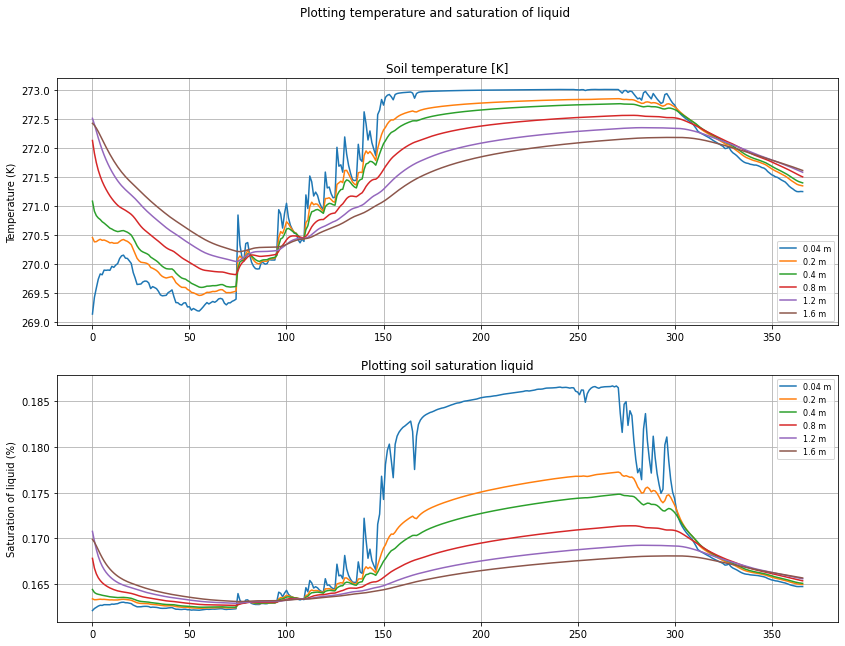

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches(w=14,h=10)
fig.suptitle('Plotting temperature and saturation of liquid')

ax1.set_title('Soil temperature [K]')
#ax1.plot(sim_data['point -0.01 temperature [K]'],label='0.01 m')
ax1.plot(sim_data['point -0.04 temperature [K]'],label='0.04 m')
ax1.plot(sim_data['point -0.2 temperature [K]'],label='0.2 m')
ax1.plot(sim_data['point -0.4 temperature [K]'],label='0.4 m')
ax1.plot(sim_data['point -0.8 temperature [K]'],label='0.8 m')
ax1.plot(sim_data['point -1.2 temperature [K]'],label='1.2 m')
ax1.plot(sim_data['point -1.6 temperature [K]'],label='1.6 m')
#ax1.plot(sim_data['point -5.0 temperature [K]'],label='5.0 m')
#ax1.plot(sim_data['point -10.0 temperature [K]'],label='10.0 m')
#ax1.plot(sim_data['point -20.0 temperature [K]'],label='20.0 m')
#ax1.plot(sim_data['point -30.0 temperature [K]'],label='30.0 m')
#ax1.plot(sim_data['point -40.0 temperature [K]'],label='40.0 m')
ax1.set_ylabel('Temperature (K)')
#ax1.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
#ax1.set_xlabel('Date (days)')
ax1.legend(fontsize=8)
ax1.grid(True)

ax2.set_title('Plotting soil saturation liquid')
#ax2.plot(sim_data['point -0.01 saturation liquid'],label='0.01 m')
ax2.plot(sim_data['point -0.04 saturation liquid'],label='0.04 m')
ax2.plot(sim_data['point -0.2 saturation liquid'],label='0.2 m')
ax2.plot(sim_data['point -0.4 saturation liquid'],label='0.4 m')
ax2.plot(sim_data['point -0.8 saturation liquid'],label='0.8 m')
ax2.plot(sim_data['point -1.2 saturation liquid'],label='1.2 m')
ax2.plot(sim_data['point -1.6 saturation liquid'],label='1.6 m')
#ax2.plot(sim_data['point -5.0 saturation liquid'],label='5.0 m')
#ax2.plot(sim_data['point -10.0 saturation liquid'],label='10.0 m')

ax2.set_ylabel('Saturation of liquid (%)')
#ax2.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
#ax2.xlabel('Date (days)')
ax2.legend(fontsize=8)
ax2.grid(True)

In [24]:
file_name

'Case5_III_su_cv'

In [25]:
sim_data_obs = pd.read_csv(f'{file_name}_obs_data.dat',sep=' ',header=None)
sim_data_obs.columns = sim_data.columns
sim_data_obs.head()

FileNotFoundError: [Errno 2] No such file or directory: 'Case5_III_su_cv_obs_data.dat'

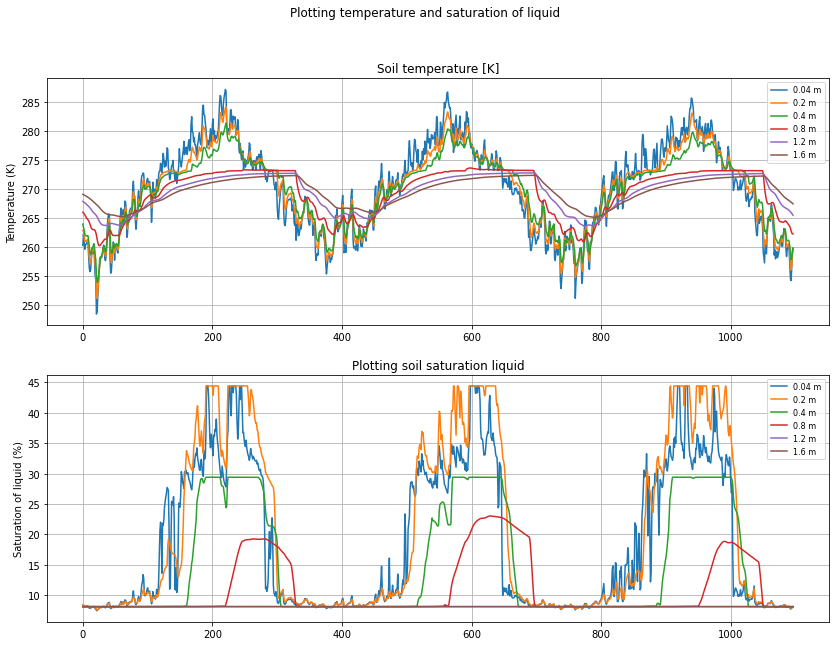

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches(w=14,h=10)
fig.suptitle('Plotting temperature and saturation of liquid')

ax1.set_title('Soil temperature [K]')
#ax1.plot(sim_data_obs['point -0.01 temperature [K]'],label='0.01 m')
ax1.plot(sim_data_obs['point -0.04 temperature [K]'],label='0.04 m')
ax1.plot(sim_data_obs['point -0.2 temperature [K]'],label='0.2 m')
ax1.plot(sim_data_obs['point -0.4 temperature [K]'],label='0.4 m')
ax1.plot(sim_data_obs['point -0.8 temperature [K]'],label='0.8 m')
ax1.plot(sim_data_obs['point -1.2 temperature [K]'],label='1.2 m')
ax1.plot(sim_data_obs['point -1.6 temperature [K]'],label='1.6 m')
#ax1.plot(sim_data_obs['point -5.0 temperature [K]'],label='5.0 m')
#ax1.plot(sim_data_obs['point -10.0 temperature [K]'],label='10.0 m')
#ax1.plot(sim_data_obs['point -20.0 temperature [K]'],label='20.0 m')
#ax1.plot(sim_data_obs['point -30.0 temperature [K]'],label='30.0 m')
#ax1.plot(sim_data_obs['point -40.0 temperature [K]'],label='40.0 m')
ax1.set_ylabel('Temperature (K)')
#ax1.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
#ax1.set_xlabel('Date (days)')
ax1.legend(fontsize=8)
ax1.grid(True)

ax2.set_title('Plotting soil saturation liquid')
#ax2.plot(sim_data_obs['point -0.01 saturation liquid'],label='0.01 m')
ax2.plot(sim_data_obs['point -0.04 saturation liquid'],label='0.04 m')
ax2.plot(sim_data_obs['point -0.2 saturation liquid'],label='0.2 m')
ax2.plot(sim_data_obs['point -0.4 saturation liquid'],label='0.4 m')
ax2.plot(sim_data_obs['point -0.8 saturation liquid'],label='0.8 m')
ax2.plot(sim_data_obs['point -1.2 saturation liquid'],label='1.2 m')
ax2.plot(sim_data_obs['point -1.6 saturation liquid'],label='1.6 m')
#ax2.plot(sim_data_obs['point -5.0 saturation liquid'],label='5.0 m')
#ax2.plot(sim_data_obs['point -10.0 saturation liquid'],label='10.0 m')

ax2.set_ylabel('Saturation of liquid (%)')
#ax2.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
#ax2.xlabel('Date (days)')
ax2.legend(fontsize=8)
ax2.grid(True)

Comments:

    * The saturation of liquid is reaching one and hence ats is finding it hard to find a solution!

#### Check the outputs in the file and also the jupyter notebook terminal - weather it is running. If all is good you can start with the pestcheck!

In [65]:
os.chdir('..')

In [66]:
os.getcwd()

'/home/rk/pestpp/pestpp/rk_model_final_4yrs/Case5_I_cv_start.demo'

In [28]:
%%time
### Check the ats_modelcmd.py file - Change the file name line of peat and mineral
os.system('python3 ats_modelcmd_cl.py')
### Make sure that the observation file is created! - Testing in cmd is better 

CPU times: user 788 µs, sys: 5.35 ms, total: 6.14 ms
Wall time: 1min 24s


0

In [26]:
# Running tempchek
#subprocess.run(['tempchek'], capture_output=True, text=True).stdout

In [27]:
file_name

'Case5_III_su_cv'

In [29]:
# Running tempchek
subprocess.run(['singularity exec /bigwork/nhgjrabl/Singularity/ats_pest_final_2.sif tempchek',f'{file_name}.xml.tpl'], capture_output=True, text=True).stdout

FileNotFoundError: [Errno 2] No such file or directory: 'singularity exec /bigwork/nhgjrabl/Singularity/ats_pest_final_2.sif tempchek'

In [70]:
# Running inschek
subprocess.run(['inschek',f'{file_name}_obs_data.dat.ins'], capture_output=True, text=True).stdout

' INSCHEK Version 17.3. Watermark Numerical Computing.\n\n Errors in file Case5_I_cv_obs_data.dat.ins ----->\n No errors encountered.\n\n 15344 observations identified in file Case5_I_cv_obs_data.dat.ins: these are \n   listed in file Case5_I_cv_obs_data.dat.obf.\n\n'

In [7]:
os.chdir(f'{directory_name}')

In [8]:
### Converting the pest control file to version 1

In [30]:
import pyemu

ModuleNotFoundError: No module named 'pyemu'

In [10]:
os.getcwd()

/home/rk/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'/home/rk/pestpp/pestpp/rk_model_final_4yrs_su/Case5_su_cv_start_cl.demo'

In [72]:
directory_name

'Case5_su_cv_start_cl.demo'

In [12]:
pst = pyemu.Pst(f"{file_name}_cf.pst")
pst.write(f"{file_name}_cf_v1.pst")

/home/rk/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


noptmax:-1, npar_adj:12, nnz_obs:15344


In [76]:
os.getcwd()

'/home/rk/pestpp/pestpp/rk_model_final_4yrs/Case5_I_cv_start.demo'

In [77]:
### Checking the pest control file once more

subprocess.run(['pestchek',f"{file_name}_cf_v1.pst"], capture_output=True, text=True).stdout

' PESTCHEK Version 17.3. Watermark Numerical Computing.\n\n Errors ----->\n No errors encountered.\n\n Warnings ----->\n It appears that the PEST control file contains a "rsi" section. PESTCHEK did \n   not check this. It can only be used by RSI_HP.\n NUMLAM is supplied as negative. This will be reset to positive. If Parallel \n   PEST or BEOPEST is used PARLAM will automatically be set to -9999.\n NOPTMAX provided as -1. No optimisation will be carried out; objective \n   function, residuals and statistics will be recorded for initial parameter \n   estimates only.\n MAXSING in the singular value decomposition section is greater than the \n   number of adjustable parameters.\n'

* If the error of DERCOM appears - Just remove 1 from the all the par_data lines!

#### Change the file name in 'ats_modelcmd.py' to pest file name

In [13]:
os.getcwd()

'/home/rk/pestpp/pestpp/rk_model_final_4yrs/Case5_I_cv_start.demo'

In [80]:
%%time
### Running pest file

os.system(f'pest {file_name}_cf_v1.pst')
#subprocess.run(['pest',f'{file_name}_cf_v1.pst','&>out.log'], capture_output=True, text=True).stdout

CPU times: user 10.7 s, sys: 2.94 s, total: 13.7 s
Wall time: 3d 17h 29min 35s


0

### Reweighting strategy - PWTADJ1


In [7]:
subprocess.run(['singularity exec /bigwork/nhgjrabl/Singularity/ats_pest_final_2.sif pwtadj1'], capture_output=True, text=True).stdout

FileNotFoundError: [Errno 2] No such file or directory: 'singularity exec /bigwork/nhgjrabl/Singularity/ats_pest_final_2.sif pwtadj1'

### Check the total objective function value in the .rec file and add in the cmd below:

 Objective function ----->

   - Sum of squared weighted residuals (ie phi)                =  **0.0196739**
   - Contribution to phi from observation group "temp"         =  0.00190865
   - Contribution to phi from observation group "mois"         =  0.0177653

In [9]:
obj_fn_value = 0.0196739 # Taken from .rec file

In [10]:
obj_fn_value/2

0.00983695

In [16]:
subprocess.run(['pwtadj1',f'{file_name}_cf_v1.pst',f'{file_name}_cf_v1_rw.pst',f'{obj_fn_value/2}'], capture_output=True, text=True).stdout

'\n PWTADJ1 version 17.3. Watermark Numerical Computing.\n\n - reading PEST control file Case5_I_cv_cf_v1.pst for first time...\n - file Case5_I_cv_cf_v1.pst read ok.\n\n - reading PEST run record file Case5_I_cv_cf_v1.rec...\n - file Case5_I_cv_cf_v1.rec read ok.\n\n - re-reading file Case5_I_cv_cf_v1.pst and writing file Case5_I_cv_cf_v1_rw.pst...\n - file Case5_I_cv_cf_v1.pst read ok.\n - file Case5_I_cv_cf_v1_rw.pst written ok.\n'

In [18]:
# Removing the out.log file since it's file size is large
subprocess.run(['rm','-rf','out.log'], capture_output=True, text=True).stdout

''

In [11]:
os.chdir(f'..')

In [12]:
os.getcwd()

'/home/rk/pestpp/pestpp/rk_model_final_4yrs'

In [13]:
file_name

'Case5_I_cv'

In [14]:
directory_name_rw = f'{file_name}_rw_2.demo'

In [15]:
directory_name_rw

'Case5_I_cv_rw_2.demo'

In [16]:
# Copying the files to a new folder
shutil.copytree(directory_name, directory_name_rw)

'Case5_I_cv_rw_2.demo'

In [17]:
os.chdir(f'{directory_name_rw}')

In [19]:
cf_name = f'{file_name}_cf_v1' # Control file name before reweighting

In [20]:
# Removing unnecessary files to provide space for the simulation
# Check once more if all the files have been removed properly
os.system(f'rm {cf_name}.drf {cf_name}.jac {cf_name}.jst {cf_name}.jco {cf_name}.mtt {cf_name}.par {cf_name}.rec {cf_name}.rei {cf_name}.res {cf_name}.sen {cf_name}.seo {cf_name}.svd {cf_name}.rst jacob.runs')

0

In [21]:
file_name

'Case5_I_cv'

In [ ]:
%%time
# Running the new re-weighted pest file
os.system(f'pestpp-glm {file_name}_cf_v1_rw.pst')
# Prefer running it on the terminal?